


# <div style="color:white;display:fill;border-radius:5px;background-color:#67a490;letter-spacing:0.1px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;margin:0;font-size:110%;text-align:center">Stroke Prediction Using Patient Data</p></div>

## <b><span style='color:#67a490'>Business Goal</span> </b>
To predict the likelihood of patients experiencing strokes by analyzing their demographic and health-related features,a machine learning predictive model is being developed in this endavour. By leveraging patient data, this model seeks to identify individuals at heightened risk, enabling healthcare providers to implement targeted prevention strategies and personalized care. 
In this notebook, I am exploring and evaluating different machine learning models to find the one that provides the best performance.
<br>

## <b><span style='color:#67a490'>Data Overview</span> </b>

The data consists of 5100 customers with information related to their age, gender, hypertension , heart disease , marital status, work type, residence type , glucose level , bmi , smoking status and stroke data. The data set also contains the customer's ID, which will be dropped before beginning the analysis. 

<font size = 3><b> Environment setup </b></font>
<br>
All the necessary Python libraries for the project are imported.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneOut, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,precision_score, recall_score, f1_score, roc_auc_score  # For Model Implementation
from math import pi # For Performance (radar Chart)
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')

## <b>Data Preprocessing</b>

We are using dataset from Kaggle and cleaning up the data for example checking for missing values and filling the missing 'bmi' values with the median.
We are also performing categorical Encoding where categorical features (gender, ever_married, work_type, Residence_type, smoking_status) are converted into numerical representations using Label Encoding.


In [6]:
# Load dataset
df = pd.read_csv('./Project/healthcare-dataset-stroke-data.csv')

# Display first few rows
display(df.head())

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Fill missing numerical values with median
df["bmi"] = df["bmi"].fillna(df["bmi"].median())

# Verifying missing values are handled 
print("Missing values after filling:\n", df.isnull().sum())



id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

Missing values:
 id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64
Missing values after filling:
 id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [8]:
# Encoding categorical variables
label_enc = LabelEncoder()
df['gender'] = label_enc.fit_transform(df['gender'])
df['ever_married'] = label_enc.fit_transform(df['ever_married'])
df['work_type'] = label_enc.fit_transform(df['work_type'])
df['Residence_type'] = label_enc.fit_transform(df['Residence_type'])
df['smoking_status'] = label_enc.fit_transform(df['smoking_status'])

In [136]:
display(df.head())

id  gender   age  hypertension  heart_disease  ever_married  work_type  \
0   9046       1  67.0             0              1             1          2   
1  51676       0  61.0             0              0             1          3   
2  31112       1  80.0             0              1             1          2   
3  60182       0  49.0             0              0             1          2   
4   1665       0  79.0             1              0             1          3   

   Residence_type  avg_glucose_level   bmi  smoking_status  stroke  
0               1             228.69  36.6               1       1  
1               0             202.21  28.1               2       1  
2               0             105.92  32.5               2       1  
3               1             171.23  34.4               3       1  
4               0             174.12  24.0               2       1

Dropping unnecessary columns like id and stroke which are not required to be a part of the training or testing dataset. We are splitting the dataset into train and test sets (80% training, 20% testing) using train_test_split.

In [16]:
x = df.drop(columns=['id', 'stroke'])
y = df["stroke"]

# X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=105, stratify=y)
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=105)


<font size = 2>
<b> Why Scale? </b>
</font>
    
We are incorporating the scaling concept to bring age and bmi on the same scale before training the model

In [18]:
# Scale numeric features
scaler = StandardScaler()
X_train[['age', 'avg_glucose_level', 'bmi']] = scaler.fit_transform(X_train[['age', 'avg_glucose_level', 'bmi']])
X_test[['age', 'avg_glucose_level', 'bmi']] = scaler.transform(X_test[['age', 'avg_glucose_level', 'bmi']])

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(4088, 10)
(1022, 10)
(4088,)
(1022,)


To identify the most effective approach for stroke prediction, we will proceed to evaluate multiple machine learning models and compare their performance.


## Logistic Regression Model
The first model we are using is the Logistic Regression model which  is a linear model ideal for binary classification tasks. It predicts the probability of a stroke based on a weighted combination of input features. 

The accuracy, precision, recall, F1-score, and ROC AUC score of the model is calculated using scikit-learn metrics.

Logistic Regression Metrics:
Accuracy: 0.75
Precision: 0.16
Recall: 0.92
F1 Score: 0.27
ROC AUC: 0.83


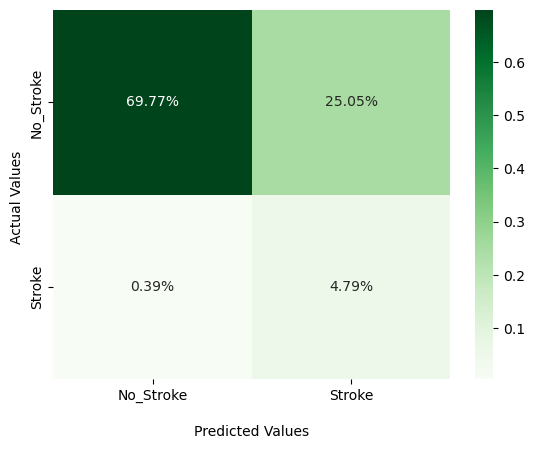

In [142]:
# LOGISTIC REGRESSION MODEL
lr = LogisticRegression(max_iter=1000, class_weight="balanced")
lr.fit(X_train, Y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression Metrics:")
print_metrics(Y_test, y_pred_lr)
plot_confusion_matrix(Y_test, y_pred_lr, "Logistic Regression")

In [144]:
# Common function to plot confusion matrix
def plot_confusion_matrix(Y_test, y_pred, model_name):
    cm = confusion_matrix(Y_test, y_pred)
    ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='Greens')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ax.xaxis.set_ticklabels(['No_Stroke','Stroke'])
    ax.yaxis.set_ticklabels(['No_Stroke','Stroke'])
    plt.show()
    
# Function to calculate and print metrics
def print_metrics(Y_test, y_pred):
    accuracy = accuracy_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred)
    recall = recall_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)
    roc_auc = roc_auc_score(Y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print(f'ROC AUC: {roc_auc:.2f}')

## Naive Bayes

Naive Bayes is a probabilistic classifier based on Bayes' Theorem with the assumption of feature independence. It’s fast, works well with high-dimensional data, and performs surprisingly well even with simple assumptions. While the “naive” independence assumption may not hold in real-world medical data like stroke prediction, it can still serve as a strong baseline and is especially effective with categorical inputs.

The metrics and the confusion matrix for the Naive Bayes is visialized below :

Naive Bayes Metrics:
Accuracy: 0.87
Precision: 0.18
Recall: 0.45
F1 Score: 0.26
ROC AUC: 0.67


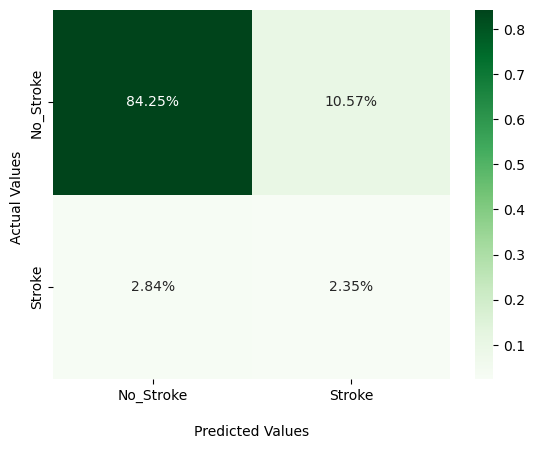

In [146]:
# NAIVE BAYES
nb = GaussianNB()
nb.fit(X_train, Y_train)
y_pred_nb = nb.predict(X_test)

print("Naive Bayes Metrics:")
print_metrics(Y_test, y_pred_nb)
plot_confusion_matrix(Y_test, y_pred_nb, "Naive Bayes")

## Decision Tree
A Decision Tree splits the data into branches based on feature values to make predictions.It provides a clear logic path for each prediction.
<br>
Since it handles both numerical and categorical data (which is the stroke prediction dataset) and can handle complex data interactions, we have picked Decision Tree also as one of our models for testing.

## Feature Importance
We have also incorporated Feature Importance revealing which variables have the greatest impact on stroke prediction. Understanding these key risk factors is crucial for developing effective prevention strategies. We infer that Age, BMI, Glucose levels are the major factors which contribute the most to the probablity of having a stroke.

Decision Tree Metrics:
Accuracy: 0.92
Precision: 0.18
Recall: 0.17
F1 Score: 0.17
ROC AUC: 0.56


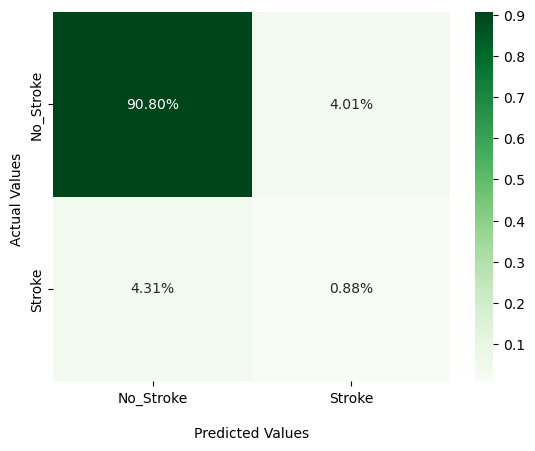


Feature Importance:
age                  0.477025
bmi                  0.188796
avg_glucose_level    0.173879
work_type            0.039557
smoking_status       0.033597
Residence_type       0.025376
ever_married         0.018195
heart_disease        0.015821
hypertension         0.014856
gender               0.012898
dtype: float64


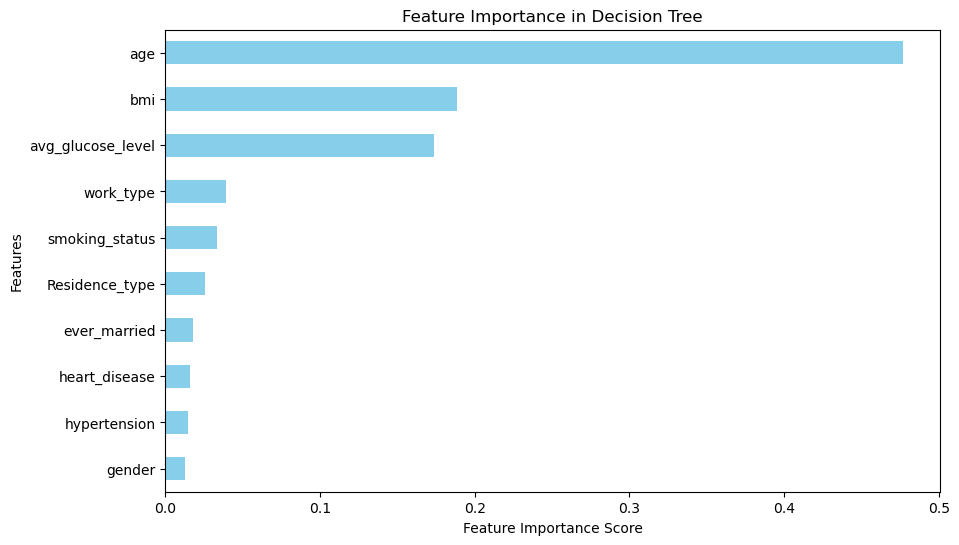

In [169]:
# DECISION TREE
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt.fit(X_train, Y_train)
y_pred_dt = dt.predict(X_test)

print("Decision Tree Metrics:")
print_metrics(Y_test, y_pred_dt)
plot_confusion_matrix(Y_test, y_pred_dt, "Decision Tree")

#from sklearn import tree
#fig = plt.figure(figsize=(25,20))
#tree.plot_tree(dt)

# Feature Importance
feature_importance = pd.Series(dt.feature_importances_, index=X_train.columns)
feature_importance = feature_importance.sort_values(ascending=False)  # Sort by importance

# Print Feature Importance
print("\nFeature Importance:")
print(feature_importance)

# Plot Feature Importance
plt.figure(figsize=(10,6))
feature_importance.plot(kind="barh", color="skyblue")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Decision Tree")
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()



## Random Forest
Random Forest is an ensemble learning method that builds multiple decision trees and combines their results. It handles nonlinear relationships well 
making it suitable for complex medical datasets and can maintain accuracy even with missing values, making it resilient when dealing with incomplete records, which is common in healthcare data. 

The metrics and the confusion matrix for the Random Forest is visualized below :

K-Fold Accuracy Scores: [0.93887531 0.94376528 0.95110024 0.9755202  0.95104039]
Mean Accuracy: 0.9520602837622286
Random Forest Metrics:
Accuracy: 0.95
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
ROC AUC: 0.50


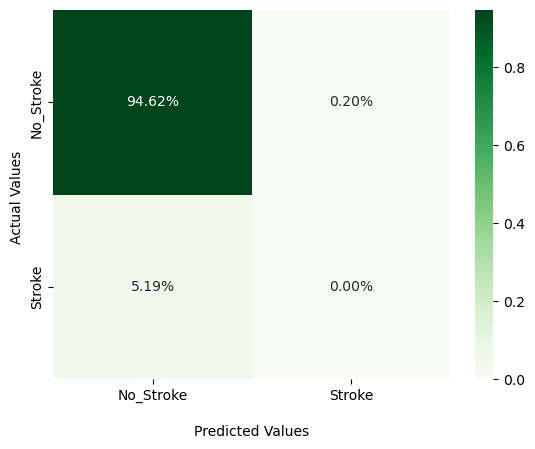

In [174]:
#RANDOM FOREST 

rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train, Y_train)
y_pred_rf = rf.predict(X_test)

# Model Training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, Y_train)

# Cross Validation Techniques

kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_scores = cross_val_score(model, X_train, Y_train, cv=kf, scoring='accuracy')
print("K-Fold Accuracy Scores:", kf_scores)
print("Mean Accuracy:", kf_scores.mean())

print("Random Forest Metrics:")
print_metrics(Y_test, y_pred_rf)
plot_confusion_matrix(Y_test, y_pred_rf, "Random Forest")


<b> Feature Importance </b>
<br>
Random Forest also incorporates Feature importance helps identify which input variables (features) have the most influence on the model’s predictions. <br>
This is crucial in identifying crucial risk factors which contribute the most to the stroke risk which is glucose level,age, bmi,smoking status which is similar to the factors identified in Decision Tree model also.

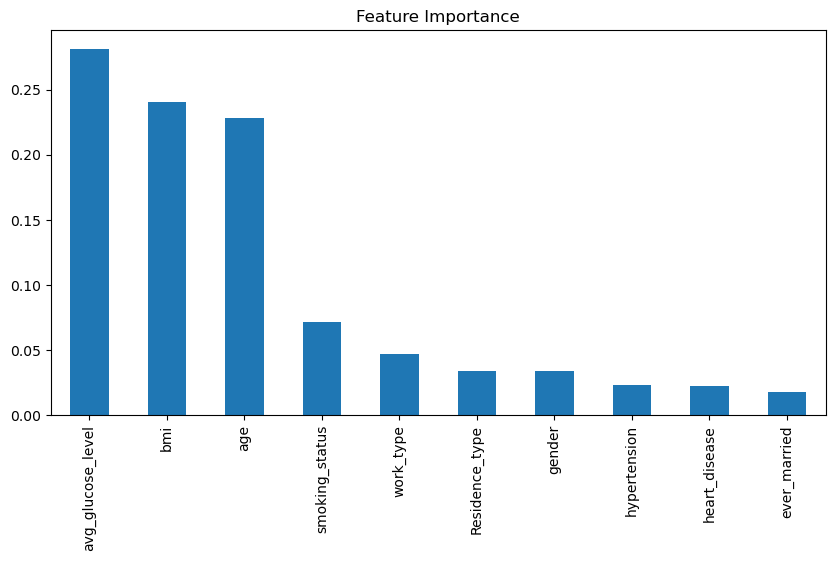

In [100]:
# Feature Importance
feature_importances = pd.Series(model.feature_importances_, index=x.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 5))
plt.title("Feature Importance")
plt.show()

## K Nearest Neighbours 

K-Nearest Neighbors predicts stroke risk by identifying the most similar patients in the dataset and predicting on the same lines. It can  clearly cluster stroke and non stroke cases making the classifications more accurate.

The metrics and the confusion matrix for the KNN is visualized below :


K-Nearest Neighbors Metrics:
Accuracy: 0.94
Precision: 0.12
Recall: 0.02
F1 Score: 0.03
ROC AUC: 0.51


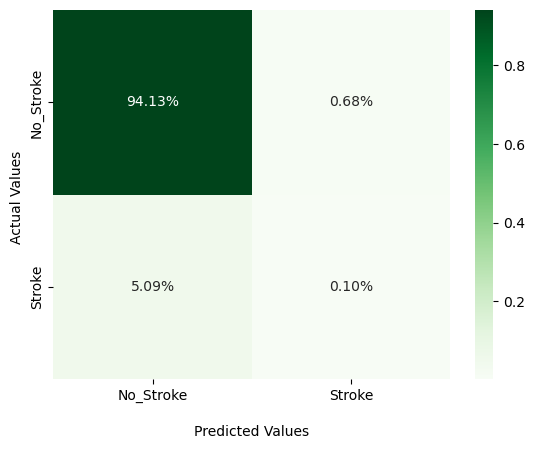

In [183]:
# K NEAREST NEIGHBOURS
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
y_pred_knn = knn.predict(X_test)

print("K-Nearest Neighbors Metrics:")
print_metrics(Y_test, y_pred_knn)
plot_confusion_matrix(Y_test, y_pred_knn, "K-Nearest Neighbors")

## Prediction models comparison
Here we are drawing a comparison of the scores of all the models listed above to determine which of the model is the most accurate and can be used for flawless stroke prediction
<br>

To gain insights into thmodel comparisonet, we use various data visualization techniques. DataFrames allow us to explore distributions and correlations efficiently using tools like `seaborn` and `matplotlib`. A **dark grid style** is applied to enhance readability and contrast in plots, making patterns easier to spotAdditionally, a **radar chart** is used to visualize the metrics (e.g., comparing features like Accuracy, Precision, ROC AUC) for individual patients, helping identify risk patterns in a visually intuitive way. a


In [129]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'K-Nearest Neighbors'],
    'Accuracy': [accuracy_score(Y_test, y_pred_lr), accuracy_score(Y_test, y_pred_nb), accuracy_score(Y_test, y_pred_dt), accuracy_score(Y_test, y_pred_rf), accuracy_score(Y_test, y_pred_knn)],
    'Precision': [precision_score(Y_test, y_pred_lr), precision_score(Y_test, y_pred_nb), precision_score(Y_test, y_pred_dt), precision_score(Y_test, y_pred_rf), precision_score(Y_test, y_pred_knn)],
    'Recall': [recall_score(Y_test, y_pred_lr), recall_score(Y_test, y_pred_nb), recall_score(Y_test, y_pred_dt), recall_score(Y_test, y_pred_rf), recall_score(Y_test, y_pred_knn)],
    'F1 Score': [f1_score(Y_test, y_pred_lr), f1_score(Y_test, y_pred_nb), f1_score(Y_test, y_pred_dt), f1_score(Y_test, y_pred_rf), f1_score(Y_test, y_pred_knn)],
    'ROC AUC': [roc_auc_score(Y_test, y_pred_lr), roc_auc_score(Y_test, y_pred_nb), roc_auc_score(Y_test, y_pred_dt), roc_auc_score(Y_test, y_pred_rf), roc_auc_score(Y_test, y_pred_knn)]
})

results

Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.739726   0.150820  0.867925  0.256983  0.800319
1          Naive Bayes  0.865949   0.181818  0.452830  0.259459  0.670688
2        Decision Tree  0.916830   0.180000  0.169811  0.174757  0.563750
3        Random Forest  0.946184   0.000000  0.000000  0.000000  0.498968
4  K-Nearest Neighbors  0.942270   0.125000  0.018868  0.032787  0.505822

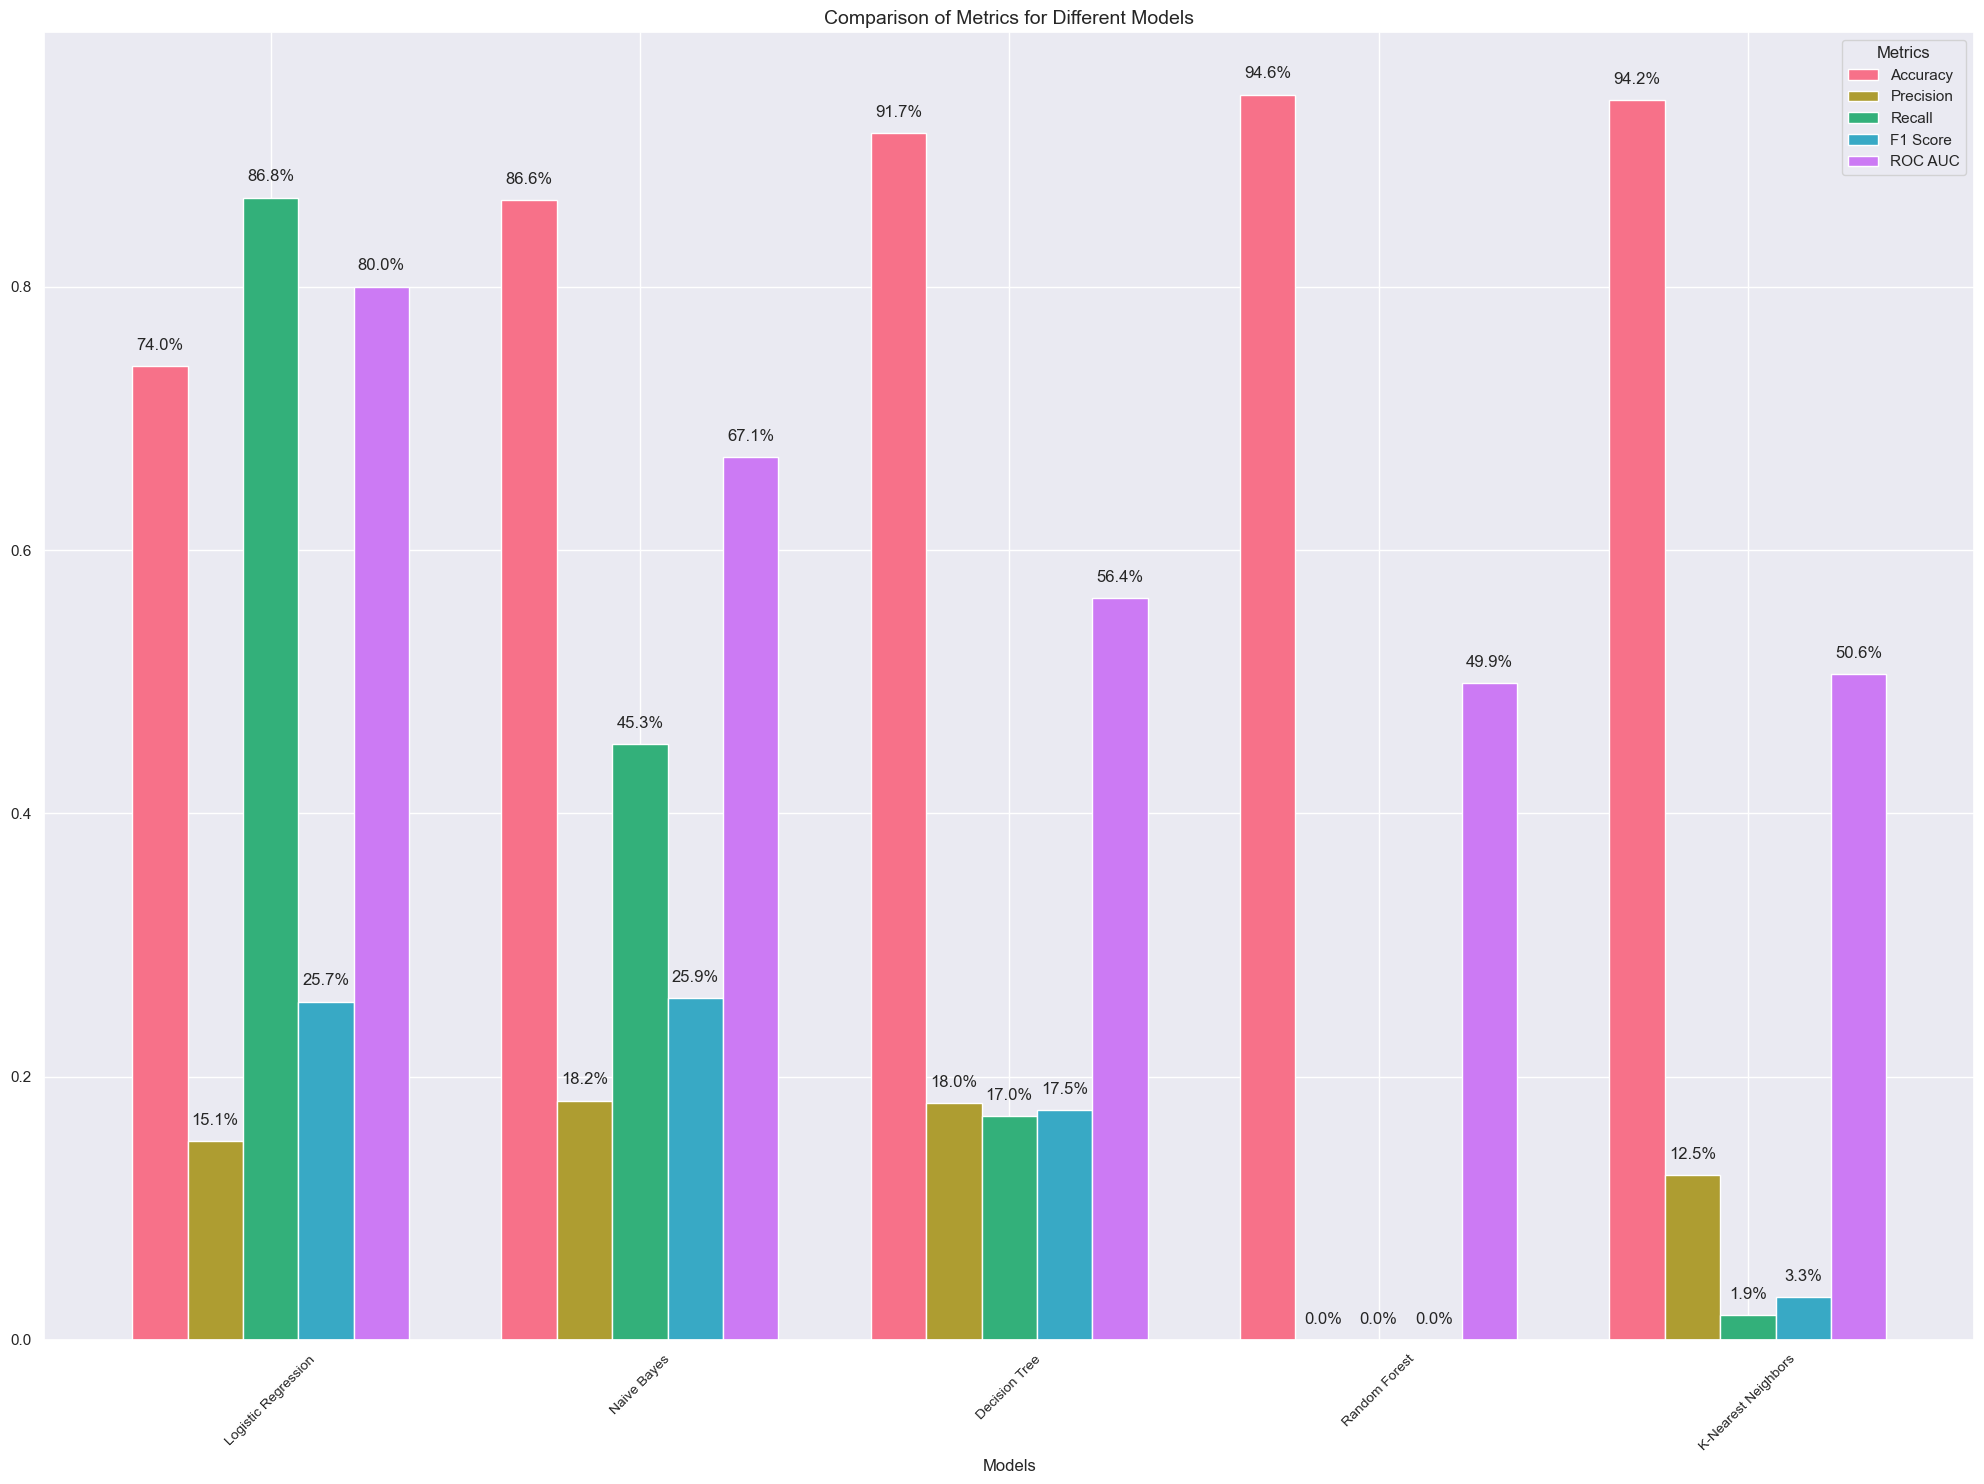

In [131]:
sns.set(style="darkgrid") # style must be one of white, dark, whitegrid, darkgrid, ticks

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
models = ['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'K-Nearest Neighbors']

accuracy = [accuracy_score(Y_test, y_pred_lr), accuracy_score(Y_test, y_pred_nb), 
            accuracy_score(Y_test, y_pred_dt), accuracy_score(Y_test, y_pred_rf), 
            accuracy_score(Y_test, y_pred_knn)]

precision = [precision_score(Y_test, y_pred_lr), precision_score(Y_test, y_pred_nb), 
             precision_score(Y_test, y_pred_dt), precision_score(Y_test, y_pred_rf), 
             precision_score(Y_test, y_pred_knn)]

recall = [recall_score(Y_test, y_pred_lr), recall_score(Y_test, y_pred_nb), 
          recall_score(Y_test, y_pred_dt), recall_score(Y_test, y_pred_rf), 
          recall_score(Y_test, y_pred_knn)]

f1 = [f1_score(Y_test, y_pred_lr), f1_score(Y_test, y_pred_nb), 
      f1_score(Y_test, y_pred_dt), f1_score(Y_test, y_pred_rf), 
      f1_score(Y_test, y_pred_knn)]

roc_auc = [roc_auc_score(Y_test, y_pred_lr), roc_auc_score(Y_test, y_pred_nb), 
           roc_auc_score(Y_test, y_pred_dt), roc_auc_score(Y_test, y_pred_rf), 
           roc_auc_score(Y_test, y_pred_knn)]

values = np.array([accuracy, precision, recall, f1, roc_auc])


colors = sns.color_palette("husl", len(metrics))

fig, ax = plt.subplots(figsize=(20,15))


bar_width = 0.15
index = np.arange(len(models))

for i, metric in enumerate(metrics):
    bars = ax.bar(index + i * bar_width, values[i], bar_width, label=metric, color=colors[i])
    
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval * 100:.1f}%', ha='center', va='bottom')

ax.set_xlabel('Models', fontsize=12)
ax.set_title('Comparison of Metrics for Different Models', fontsize=14)
ax.set_xticks(index + bar_width * 2)
ax.set_xticklabels(models, fontsize=10)
ax.legend(title='Metrics')

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

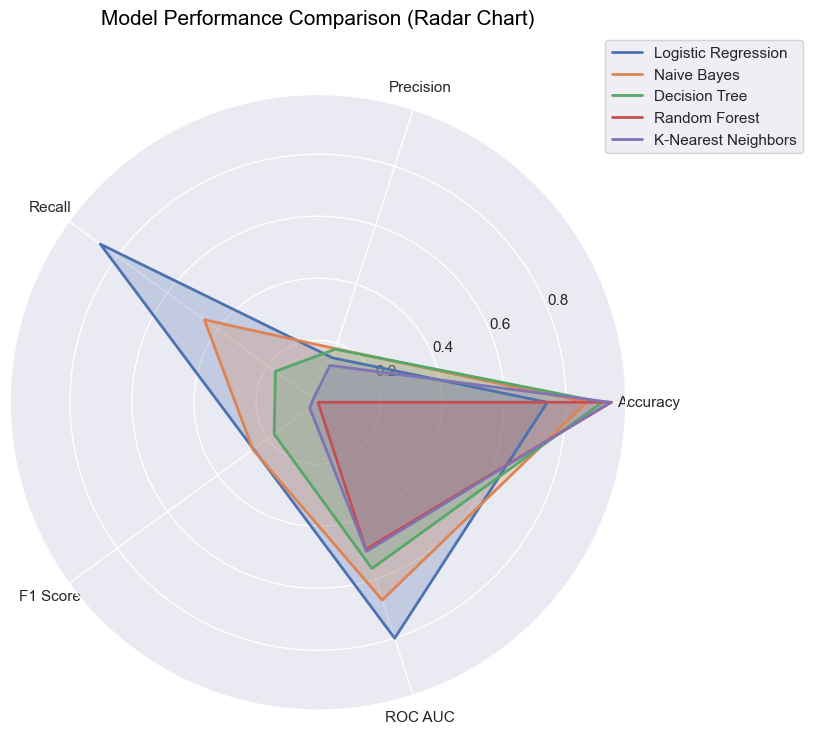

In [133]:
# Data for radar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
models = ['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'K-Nearest Neighbors']
values = np.array([accuracy, precision, recall, f1, roc_auc])

num_metrics = len(metrics)

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, model in enumerate(models):
    values_for_model = values[:, i]
    # Add first value to the end to close the radar chart loop
    values_for_model = np.concatenate((values_for_model, [values_for_model[0]]))
    
    angles = [n / float(num_metrics) * 2 * pi for n in range(num_metrics)]
    angles += angles[:1]  # Complete the loop
    
    ax.plot(angles, values_for_model, linewidth=2, label=model)
    ax.fill(angles, values_for_model, alpha=0.25)

plt.xticks(angles[:-1], metrics)

plt.title('Model Performance Comparison (Radar Chart)', size=15, color='black', y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()

## Final Outcome:
We have completed a stroke prediction machine learning model using different models! We built and compared stroke prediction models! 
<br>
🚀 ✅ Random Forest performed best and can be used as a foundation for clinical decision support systems 🎉

